# Bin Packing Problem (BPP)

Online Bin Packing Problem with bins containing 1D resource.

state/action/reward formulation are inspired from:  https://epub.jku.at/obvulihs/download/pdf/6996324?originalFilename=true

Short description (P22,P23):
* **BPP specification:** 50 items of size 2 and 50 of size 3. Bins have a capacity of 9.
* **Observable state:** [B_0, B_1, ... B_n-1, I]. B_i is the number of bins of filling level i. I is the new incoming item size.
* **Action space:**  Select a bin according its filling level. The action 0 means "we open a new bin".
* **Reward at a given timestep:** 0 if an already existing bin is used, otherwise the negative incremental waste (reward=BIN_SIZE - I). Penalty of -1000 is given if we enter in one of those situation: bin overflow or when the action try to select an innexisting bin.



In [1]:
from rl_factory import rl_agent_factory # Factory to build RL agents
from rl_factory import default_hyperparam_factory # Factor to make easier hyperparameter setting
from EnvBinPacking import EnvBinPacking # <- Definition of the BPP. Global variables contains bins size and items distribution, number of items...
from AgentRL import AgentRLLIB
from AgentHeuristic import AgentBestFit
import numpy as np

# Environment pointer
env_config = {"action_type": "discrete"} # PPO implementation fits {"continuous" or "discrete"}. DQN "discrete". DDPG "continuous".
env_class=EnvBinPacking # ptr on the environment class (not an OOP object)

## Reinforcement Learning

In [2]:
# build the RL agent
rl_name = "PPO" 
hyperparameters = default_hyperparam_factory(rl_name)

# update value similar to the publication
hyperparameters["lr"]=1e-4 # <---Sensisitive between slow-smooth and fast-chaotic . Original paper uses 3e-4.
hyperparameters["deep"]=2
hyperparameters["wide"]=16
hyperparameters["train_batch_size"]=64
hyperparameters["sgd_minibatch_size"]=64
hyperparameters["lambda"]=0.99
hyperparameters["grad_clip"]=0.3
hyperparameters["num_rollout_workers"]=4

# Build the Trainer (contains RL object and Environment simulator object)
rllib_trainer = rl_agent_factory(rl_name, hyperparameters, env_class, env_config=env_config)

2023-02-01 23:30:40,340	WARNING deprecation.py:47 -- DeprecationWarning: `algo = Algorithm(env='<class 'EnvBinPacking.EnvBinPacking'>', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('<class 'EnvBinPacking.EnvBinPacking'>').build()` instead. This will raise an error in the future!
2023-02-01 23:30:44,223	INFO worker.py:1538 -- Started a local Ray instance.
(RolloutWorker pid=8953) 2023-02-01 23:30:50,541	WARNING env.py:147 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2023-02-01 23:30:53,316	INFO trainable.py:172 -- Trainable.setup took 12.659 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-02-01 23:30:53,317	WARNING util.py:66 -- Install gputil for GPU system monitoring.


In [3]:
agent=AgentRLLIB(rllib_trainer, env_class, env_config) 

scores=[]
for ep in range(100):
    for it in range(100):
        agent.train()

    # The environment is stochastic (random shuffling of items)
    ls=[agent.evaluate()['cumulated_rewards'] for i in range(30)] # ls: list_scores
    m=round(np.mean(ls))
    print(f"Info: {m} +- {round(np.std(ls))} min:{round(np.min(ls))} max:{round(np.max(ls))}", )
    scores.append((m,round(np.std(ls))))

Info: -989 +- 267 min:-1395 max:-624
Info: -816 +- 317 min:-1399 max:-505
Info: -749 +- 260 min:-1306 max:-559
Info: -743 +- 282 min:-1546 max:-598
Info: -702 +- 208 min:-1222 max:-526
Info: -926 +- 312 min:-1422 max:-421
Info: -676 +- 202 min:-1074 max:-498
Info: -676 +- 228 min:-1286 max:-484
Info: -834 +- 265 min:-1158 max:-416
Info: -714 +- 309 min:-1496 max:-462
Info: -619 +- 203 min:-1419 max:-498
Info: -626 +- 209 min:-1018 max:-454
Info: -616 +- 298 min:-1471 max:-435
Info: -670 +- 306 min:-1421 max:-418
Info: -1237 +- 143 min:-1370 max:-1000
Info: -1046 +- 396 min:-1371 max:-341
Info: -606 +- 381 min:-1391 max:-340
Info: -910 +- 444 min:-1382 max:-350
Info: -1099 +- 348 min:-1366 max:-359
Info: -1138 +- 89 min:-1275 max:-1000
Info: -1118 +- 309 min:-1383 max:-368
Info: -593 +- 342 min:-1402 max:-375
Info: -1162 +- 74 min:-1274 max:-1000
Info: -659 +- 328 min:-1398 max:-432
Info: -593 +- 246 min:-1060 max:-440
Info: -561 +- 208 min:-1048 max:-447
Info: -553 +- 191 min:-1042 max

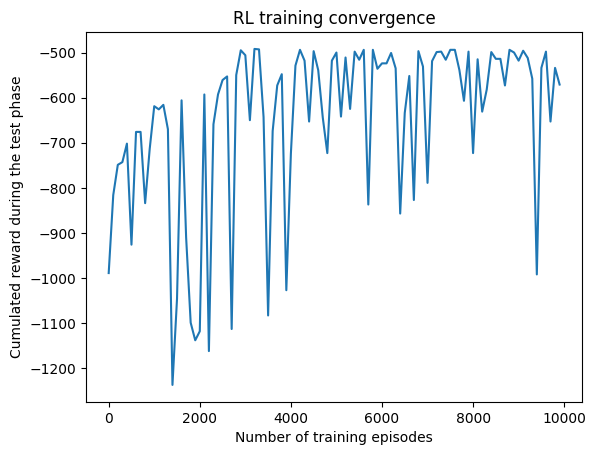

Best score:  -492


In [13]:
import numpy as np
import matplotlib.pyplot as plt
 
# Dataset
x = np.array([i*100 for i in range(len(scores))])
y = np.array([m for m,s in scores])
 
# Plotting the Graph
plt.plot(x, y)
plt.title("RL training convergence")
plt.xlabel("Number of training episodes")
plt.ylabel("Cumulated reward during the test phase")
plt.show()

print("Best score: ", np.max(np.array(scores)[:,0]))

## Heuristics (Best Fit)

In [14]:
agent = AgentBestFit(None, env_class, env_config)
ls=[agent.evaluate()['cumulated_rewards'] for i in range(30)] # ls: list_scores
print(f"Info: {np.mean(ls)} +- {round(np.std(ls))} min:{round(np.min(ls))} max:{round(np.max(ls))}", )

Info: -193.0 +- 0 min:-193 max:-193


In [ ]:
More information on the last state

In [16]:
print(agent.evaluate())
# Final state [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0., 13.,  0.] 
# * It means: "1 bin  with filling level = 2, 13 bins with filling level = 8 (the other bins are never displaid)"
# * The last 0 is a default value encoding the fact there is no remaining object to place (end of the simulation).

{'cumulated_rewards': -193.0, 'last_reward': -7.0, 'last_state': array([ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0., 13.,  0.], dtype=float32), 'last_action': 0}


Conclusion: The original paper reports -511 scores with RL, it seems well reproduced: the learning curve reach -511 several times and the best produced version is -492. However, on this simple environment, simple Best Fist is much more performant and is stabler than RL.